In [1]:
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore bugged CUDA errors; must precede tf import
import tensorflow as tf
keras = tf.keras # autocomplete workaround; lazy-loading
from keras import layers
keras.utils.set_random_seed(1996)
if len(tf.config.list_physical_devices('GPU')) > 0:
    keras.mixed_precision.set_global_policy("mixed_float16") # NVIDIA speed optimization
else: raise SystemError('No GPU detected.') # CPU overheats

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [2]:
# !sudo rmmod nvidia_uvm && sudo modprobe nvidia_uvm
# ^ run once if TF fails to detect GPU

v1

In [3]:
def create_discriminator(input_shape:tuple, verbose:bool=True) -> keras.Sequential:
    assert len(input_shape) == 3
    d = keras.Sequential(
        [
            layers.InputLayer(input_shape),
            layers.Conv2D(img_scale, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(img_scale*2, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(img_scale*2, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid")
        ],
        name='discriminator'
    )
    if verbose:
        print(d.summary())
    return d

In [4]:
def create_generator(input_shape:tuple, verbose:bool=True) -> keras.Sequential:
    assert len(input_shape) == 1
    is_int = input_shape[0]
    is_mult = int(is_int/16)  # don't ask me why
    g = keras.Sequential(
        [
            layers.InputLayer(input_shape),
            layers.Dense(is_mult * is_mult * is_int),
            layers.Reshape((is_mult, is_mult, is_int)),
            layers.Conv2DTranspose(is_int, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(is_int*2, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(is_int*4, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(4, kernel_size=5, padding='same', activation='sigmoid')
        ],
        name='generator'
    )
    if verbose:
        print(g.summary())
    return g

In [5]:
data_root = './.data'
raw_path = os.path.join(data_root, 'pokedex')

img_scale = 64
img_size = (img_scale, img_scale)
img_shape = img_size + tuple([4])
latent_dim = tuple([img_scale*2])

dataset = keras.preprocessing.image_dataset_from_directory(
    raw_path, 
    label_mode=None, 
    color_mode='rgba', 
    image_size=img_size, 
    batch_size=64
)

discriminator = create_discriminator(img_shape)
generator = create_generator(latent_dim)

Found 891 files belonging to 1 classes.
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Fla

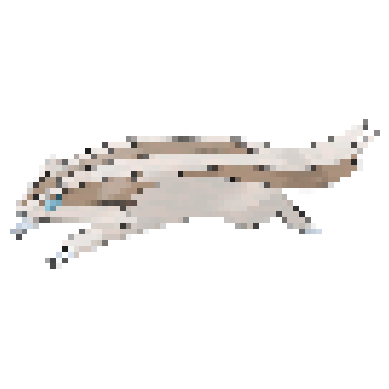

In [6]:
for x in dataset:
    plt.axis('off')
    plt.imshow((x.numpy()).astype("int32")[0])
    break

v2

In [7]:
import dcgan_v2 as v2

In [8]:
dataset, image_shape, batch_size = v2.load_mnist_dataset()

In [9]:
generator = v2.create_generator(image_shape)

In [10]:
import tensorflow as tf
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

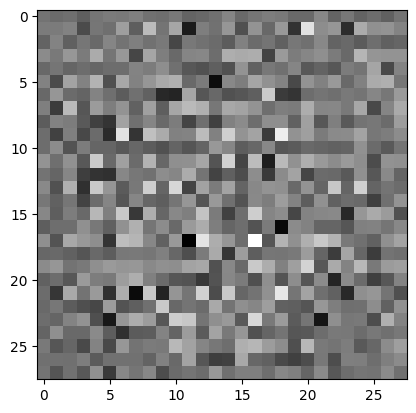

In [11]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Found 891 files belonging to 1 classes.


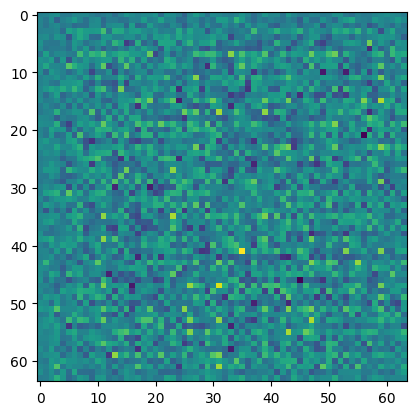

In [12]:
dataset, image_shape, batch_size = v2.load_pokemon_dataset()
generator = v2.create_generator(image_shape)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [13]:
discriminator = v2.create_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.000605]], shape=(1, 1), dtype=float16)


v2 data import

In [14]:
from dcgan_v2 import load_mnist_dataset, load_pokemon_dataset
import matplotlib.pyplot as plt

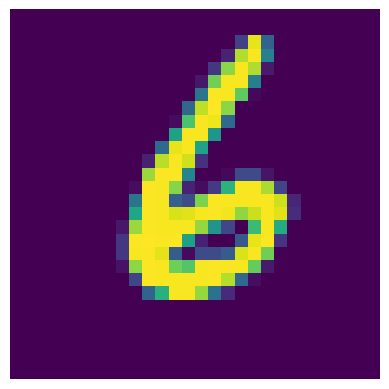

In [15]:
dataset, image_shape, batch_size = load_mnist_dataset()
sample = None
for x in dataset:
    sample = x
    break
plt.axis("off")
plt.imshow((sample.numpy() * 255).astype("int32")[0])

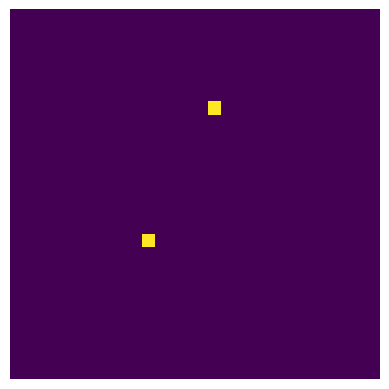

In [16]:
plt.axis("off")
plt.imshow((sample.numpy()).astype("int32")[0])

Found 891 files belonging to 1 classes.


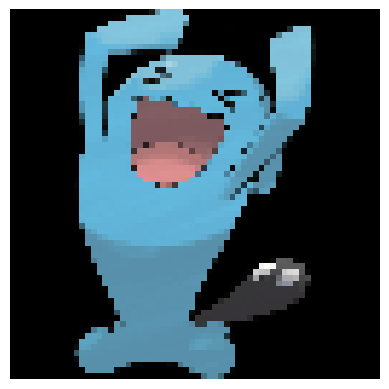

In [17]:
dataset, image_shape, batch_size = load_pokemon_dataset()
sample = None
for x in dataset:
    sample = x
    break
plt.axis("off")
plt.imshow((sample.numpy() * 255).astype("int32")[0])

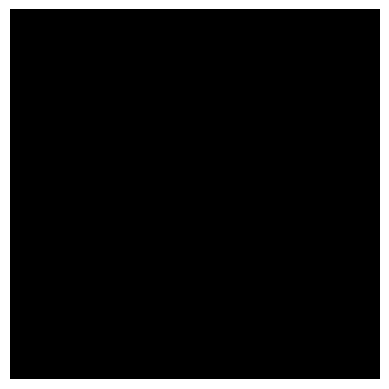

In [18]:
plt.axis("off")
plt.imshow((sample.numpy()).astype("int32")[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


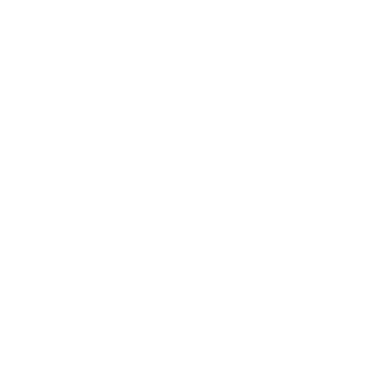

In [19]:
plt.axis("off")
plt.imshow(((sample.numpy() + 127.5)* 127.5).astype("int32")[0])

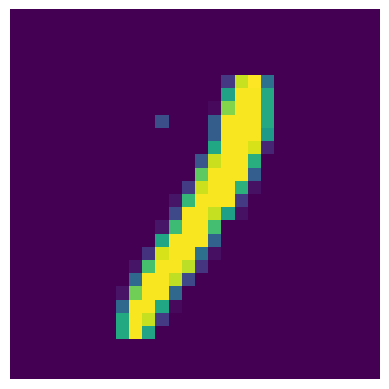

In [20]:
dataset, image_shape, batch_size = load_mnist_dataset()
sample = None
for x in dataset:
    sample = x
    break
plt.axis("off")
plt.imshow((sample.numpy() * 255).astype("int32")[0])

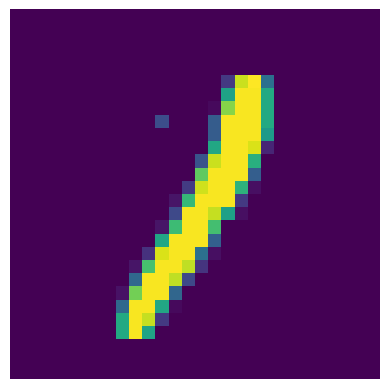

In [21]:
plt.axis("off")
plt.imshow(((sample.numpy() + 127.5)* 127.5).astype("int32")[0])

v3

In [22]:
import dcgan_v3 as v3
dataset = v3.load_dataset('.data/pokedex/')

Found 891 files belonging to 1 classes.


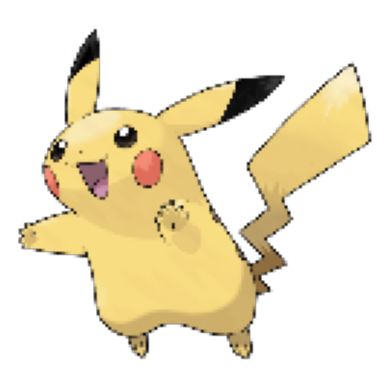

In [23]:
next(v3.get_sample(dataset))
pass

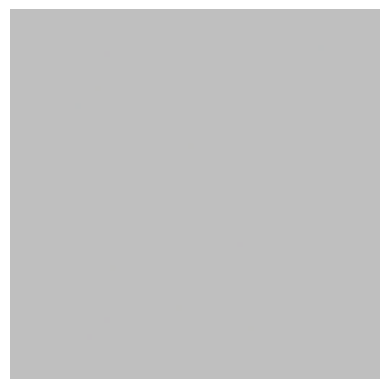

In [24]:
generator = v3.make_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
image = (generated_image.numpy() * 255).astype("uint8")[0]
# image = generated_image[0, :, :, :] # for whatever reason slicing only worked for 1 channel at a time
plt.axis('off')
plt.imshow(image)
pass

In [25]:
# image = (generated_image[1].numpy() * 255).astype('uint8')
# plt.imshow(image)
# image

In [26]:
discriminator = v3.make_discriminator()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float16, numpy=array([[-0.05792]], dtype=float16)>

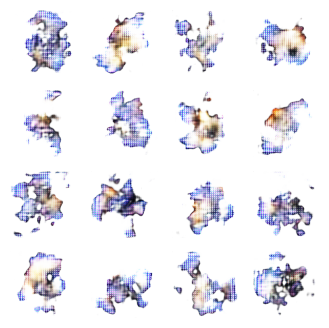

200 epochs completed in 1527.4s


In [27]:
v3.train(generator, discriminator, dataset, 200)
pass # note: output is a continuation of prior training

In [ ]:
# checkpoint: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif